# Feedforward Neural Network on GPU with pytorch

Using the MNIST dataset.

- [Data](#data)
- [Neural Network](#nn)
- [Using GPU](#gpu)
- [Training the model](#training)
- [Summary and Further Reading](#summary)


<div id="xx" />

In the previous notebook, we trained a logistic regression model to identify handwritten digits from the MNIST dataset. We also noticed that it"s quite difficult to improve the accuracy due to the limited power of the model. In this notebook, we"ll try to improve upon it using a feedforward neural network. 

<div id="data" />

## Data

The data preparation is identical to the previous notebook. We begin by importing the required modules & classes.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [2]:
# Change download=True to download data if not exists
dataset = MNIST(
    root="../data/pytorch_data",
    download=False,
    transform=ToTensor()
)

batch_size = 128

val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(
    train_ds,
    batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size*2,
    num_workers=4,
    pin_memory=True
)

len(train_ds), len(val_ds)

(50000, 10000)

You can take a look into de [documentation](https://pytorch.org/docs/stable/data.html) the meaninig of `num_workers` and `pin_memory`.

Let"s visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We"ll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `atplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


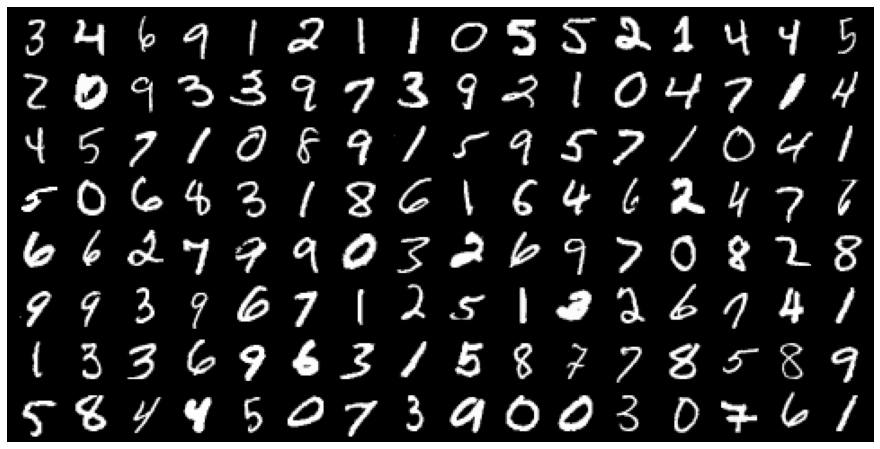

In [3]:
for images, _ in train_loader:
    print("images.shape:", images.shape)
    plt.figure(figsize = (16,8))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

<div id="nn" />

## Neural Network Model

To improve upon logistic regression, we"ll create a neural network with one **hidden layer**. Here"s what this means:

- Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilities), we"ll use two `nn.Linear` objects. Each of these is called a layer in the network.

- The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

- The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

- The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also knowns as the output layer), which transforms it into a matrix of size `batch_size x 10`, identical to the output of the logistic regression model.

Introducing a hidden layer and an activation function allows the model to learn more complex, multi-layered and non-linear relationships between the inputs and the targets. Here"s what it looks like visually:

---

![hidden-layer](../images/pytorch-images/layers.png)

---

The activation function we"ll use here is called a **Rectified Linear Unit or ReLU**, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [4]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [5]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {"val_loss": loss, "val_acc": acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["val_loss"], result["val_acc"]))

We"ll create a model that contains a hidden layer with 32 activations (you can change this parameter).

In [6]:
input_size = 784
hidden_size = 32
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let"s take a look at the model"s parameters. We expect to see one weight and bias matrix for each of the layers.

In [7]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let"s try and generate some outputs using our model. We"ll take the first batch of 128 images from our dataset, and pass them into our model.

In [8]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print("Loss:", loss.item())
    break

print("outputs.shape : ", outputs.shape)
print("Sample outputs :\n", outputs[:2].data)

Loss: 2.2968883514404297
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1201,  0.2217,  0.1484, -0.0228, -0.0448,  0.1302, -0.0420, -0.1302,
         -0.1301, -0.1829],
        [ 0.1167,  0.2309,  0.1731, -0.0775, -0.1171,  0.1648, -0.0419, -0.0879,
         -0.0216, -0.1597]])


<div id="gpu" />

## Using GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers.

We can check if a GPU is available and the required NVIDIA CUDA drivers installed using `torch.cuda.is_available`.

In [9]:
torch.cuda.is_available()

False

Let"s define a helper function to ensure that our code uses the GPU if available, and defaults to using the CPU if it isn"t.

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
device = get_default_device()
device

device(type='cpu')

Next, let"s define a function that can move data and model to a chosen device.

In [11]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [12]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as a batches are accessed. Interestingly, we don"t need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data, and an `__len__` method to get the number of batches.

In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Tensors that have been moved to the GPU"s RAM have a `device` property which includes the word `cuda`. Let"s verify this by looking at a batch of data from `valid_dl`.

In [15]:
for xb, yb in val_loader:
    print("xb.device:", xb.device)
    print("yb:", yb)
    break

xb.device: cpu
yb: tensor([7, 3, 3, 4, 3, 8, 1, 5, 2, 2, 0, 1, 0, 2, 1, 2, 4, 8, 8, 8, 8, 9, 7, 0,
        2, 2, 3, 7, 9, 7, 6, 1, 9, 7, 9, 1, 2, 5, 8, 9, 2, 1, 5, 3, 2, 8, 6, 1,
        1, 4, 8, 8, 0, 8, 5, 3, 9, 6, 7, 8, 4, 7, 7, 5, 0, 6, 7, 6, 3, 5, 7, 3,
        6, 7, 1, 4, 3, 8, 4, 5, 3, 4, 8, 0, 1, 1, 8, 9, 4, 0, 1, 7, 5, 2, 4, 7,
        4, 0, 3, 2, 3, 3, 8, 2, 9, 3, 9, 6, 3, 1, 6, 8, 8, 5, 7, 5, 1, 2, 7, 9,
        5, 0, 1, 2, 2, 8, 9, 9, 1, 0, 8, 8, 7, 3, 5, 7, 8, 8, 4, 2, 7, 3, 1, 7,
        7, 9, 9, 2, 4, 1, 8, 4, 4, 1, 8, 4, 8, 0, 6, 2, 1, 9, 6, 3, 8, 8, 9, 3,
        7, 4, 3, 3, 5, 5, 5, 9, 4, 7, 6, 9, 3, 4, 3, 5, 0, 8, 3, 5, 3, 4, 9, 5,
        7, 3, 2, 8, 4, 0, 0, 7, 0, 1, 0, 8, 1, 4, 7, 5, 6, 2, 6, 6, 1, 0, 3, 0,
        1, 0, 4, 7, 9, 6, 5, 3, 2, 6, 0, 6, 6, 5, 2, 0, 3, 1, 0, 8, 9, 8, 2, 8,
        9, 1, 0, 0, 2, 8, 4, 8, 8, 5, 2, 3, 2, 5, 1, 3])


<div id="training" />

## Tarining the model

We can use the exact same training loops from the logistic regression notebook.

In [16]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Before we train the model, we need to ensure that the data and the model"s parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model"s parameters to the right device. 

In [17]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let"s see how the model performs on the validation set with the initial set of weights and biases.

In [18]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.30509614944458, 'val_acc': 0.1171875}]

In [19]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2576, val_acc: 0.9259
Epoch [1], val_loss: 0.1962, val_acc: 0.9401
Epoch [2], val_loss: 0.1688, val_acc: 0.9507
Epoch [3], val_loss: 0.1682, val_acc: 0.9488
Epoch [4], val_loss: 0.1621, val_acc: 0.9535


In [20]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1345, val_acc: 0.9600
Epoch [1], val_loss: 0.1334, val_acc: 0.9604
Epoch [2], val_loss: 0.1342, val_acc: 0.9610
Epoch [3], val_loss: 0.1317, val_acc: 0.9624
Epoch [4], val_loss: 0.1336, val_acc: 0.9606


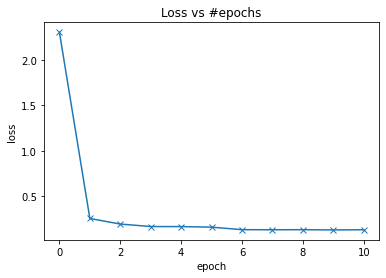

In [21]:
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs #epochs");

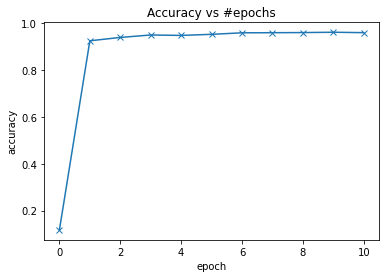

In [22]:
accuracies = [x["val_acc"] for x in history]
plt.plot(accuracies, "-x")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Accuracy vs #epochs");

Our current model outperforms the logistic regression model (which could only reach around 86% accuracy) by a huge margin! It quickly reaches an accuracy of 97%, but doesn"t improve much beyond this. To improve the accuracy further, we need to make the model more powerful. As you can probably guess, this can be achieved by increasing the size of the hidden layer, or adding more hidden layers.